In [0]:
from google.colab import files

uploaded = files.upload() 

Saving test.txt to test.txt
Saving train.txt to train.txt


In [0]:
! pip install contractions

We are using Contractions library from python to expand contractions. eg. I've, couldn't, doesn't etc.


In [0]:
import contractions
contractions.fix("I've do this")

'I have do this'

In [0]:
ls

sample_data/  test.txt  train.txt


In [0]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

import nltk
import re
import pickle

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras.engine.topology import Layer
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, Flatten, MaxPool1D, Activation, Dropout, Input, Lambda, TimeDistributed 
from keras.layers.embeddings import Embedding
from keras.models import Model
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from sklearn import preprocessing
import keras



Using TensorFlow backend.


In [0]:
# clean the text

def clean_text(texts):
    
    new_text = []
    
    
    for a in texts:
      
        
        text = contractions.fix(a)
        text = text.lower()
       
        text = re.sub(r'https?:\/\/.*[\r\n]*', '', text,  
                  flags=re.MULTILINE)
        text = re.sub(r'\<a href', ' ', text)
        text = re.sub(r'&amp;', '', text) 
        text = re.sub(r'[_"\-;%()|+&=*%,!?:#$@\[\]/]', ' ', text)
        text = re.sub(r'<br />', ' ', text)
    
        text = re.sub(r'\'', ' ', text)
        
        new_text.append(text)
    
    return new_text

In [0]:
train = open('train.txt')
test = open('test.txt')

In [0]:
df = pd.read_csv(train, sep= '\t', error_bad_lines=False, names=['Intent', 'Text'])

In [0]:
test_df = pd.read_csv(test, sep= '\t', error_bad_lines=False, names=['Intent','Text'])

In [0]:
train_df, val_df = train_test_split(df, test_size = 0.1, random_state = 112)

In [0]:
train_X = clean_text(train_df['Text'])
train_y = train_df['Intent'].tolist()

val_X = clean_text(val_df['Text'])
val_y = val_df['Intent'].tolist()

test_X = clean_text(test_df['Text'])
test_y = test_df['Intent'].tolist()

Label encoder is used from scikit learn library to encode the labels, in this case the labels are ''"Yes" and "NO". By using label encoder we encode them in numeric form


In [0]:
le = preprocessing.LabelEncoder()
le.fit(train_y + val_y)


LabelEncoder()

In [0]:
def encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)
def decode(le, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le.inverse_transform(dec)

In [0]:
# we are taking only upto 150 words from each text sentence.

train_text = [' '.join(t.split()[0:150]) for t in train_X]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]

val_text = [' '.join(t.split()[0:150]) for t in val_X]
val_text = np.array(val_text, dtype=object)[:, np.newaxis]

test_text = [' '.join(t.split()[0:150]) for t in test_X]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]

In [0]:
train_label = encode(le, train_y)
val_label = encode(le, val_y)
test_label = encode(le, test_y)

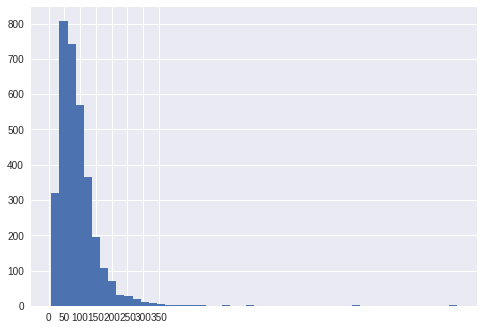

In [0]:
length = []

for t in train_X:
  length.append(len(t))

plt.hist(length, bins = 50)
plt.xticks(range(0, 400, 50))
plt.show()
  

we are using elmo embedding. It is context based word embedding diffrent from glove and word2vec.

In [0]:
url = "https://tfhub.dev/google/elmo/2"
embed = hub.Module(url)


INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/elmo/2'.
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/elmo/2'.


In [0]:
def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]


In [0]:
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
dense = Dense(256, activation='relu')(embedding)
pred = Dense(2, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 514       
Total params: 262,914
Trainable params: 262,914
Non-trainable params: 0
_________________________________________________________________


In [0]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model.fit(train_text, train_label, validation_data=(val_text, val_label),epochs=5, batch_size=32)
    model.save_weights('./elmo-model.h5')


Train on 3291 samples, validate on 366 samples
Epoch 1/5
3291/3291 [==============================] - 69s 21ms/step - loss: 0.5231 - acc: 0.7293 - val_loss: 0.4570 - val_acc: 0.7787
Epoch 2/5
3291/3291 [==============================] - 67s 20ms/step - loss: 0.4556 - acc: 0.7837 - val_loss: 0.4357 - val_acc: 0.7896
Epoch 3/5
3291/3291 [==============================] - 66s 20ms/step - loss: 0.3931 - acc: 0.8283 - val_loss: 0.4242 - val_acc: 0.8087
Epoch 4/5
3291/3291 [==============================] - 68s 21ms/step - loss: 0.3775 - acc: 0.8274 - val_loss: 0.4640 - val_acc: 0.7814
Epoch 5/5
3291/3291 [==============================] - 67s 20ms/step - loss: 0.3476 - acc: 0.8390 - val_loss: 0.4730 - val_acc: 0.7978


In [0]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('./elmo-model.h5')  
    predicts = model.evaluate(test_text, test_label, batch_size= 32, verbose=1)



Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f112865cbe0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


992/992 [==============================] - 21s 21ms/step


The accuracy of our model is 86% in test set.

In [0]:
predicts

[0.338622011604809, 0.8679435483870968]